# Predicting Rent of a Property

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import pickle

In [2]:
# Display all columns and rows

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Helper Functions

In [3]:
def create_premium_house_feature(x):
    if x["garage"] == 1 and x["pool"] == 1 and x["fireplace"] == 1 and x["bed"] > 3 and x["bathroom_combined"] > 3:
        return 1
    return 0

In [4]:
# Function to get VIF (Variation Inflation Factor)

def get_VIF(X_train):
    # A dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

## 1. Data Exploration

In [122]:
# Load Train and Test Data

TRAIN_DATA_PATH = "../data/train.csv"
TEST_DATA_PATH = "../data/test.csv"

main_df = pd.read_csv(TRAIN_DATA_PATH, encoding = "UTF-8")
val_df = pd.read_csv(TEST_DATA_PATH, encoding = "UTF-8")

main_df.head()

,id,county,city,zipcode,address,state,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,property_type,garage,yearbuilt,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent
0,train_0,NaN,WEXFORD,NaN,266 Clematis Dr Allegheny County,PA,40.618200,-80.077600,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,2,1,2000,Condo,1,2008,0,1,0,4086.388045,54476.09,5.1,3.48,2.4,2400
1,train_1,NaN,WHITEHALL,NaN,2310 N 1st Ave Lehigh County,PA,40.649906,-75.478940,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,2,1,1,1100,Condo,0,1935,0,0,0,2247.513425,54476.09,5.1,3.48,2.4,995
2,train_2,NaN,WHITEHALL,NaN,3338 St Stephens Ln Lehigh County,PA,40.646282,-75.510056,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,2,1,1522,Condo,0,2006,0,1,1,3109.741302,54476.09,5.1,3.48,2.4,1740
3,train_3,NaN,WAYNESBORO,NaN,97 W Main St Franklin County,PA,39.756992,-77.579704,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,1,1,1150,Condo,0,1960,0,0,0,2349.673126,54476.09,5.1,3.48,2.4,675
4,train_4,NaN,QUAKERTOWN,NaN,200 E Broad St Bucks County,PA,40.441177,-75.332540,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,2,1,1000,SFR,0,1960,0,0,0,2043.194023,54476.09,5.1,3.48,2.4,1300


In [123]:
main_df.shape

(24269, 35)

In [124]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24269 entries, 0 to 24268
Data columns (total 35 columns):
id                       24269 non-null object
county                   24235 non-null object
city                     24269 non-null object
zipcode                  24235 non-null float64
address                  23317 non-null object
state                    24269 non-null object
latitude                 24269 non-null float64
longitude                24269 non-null float64
cemetery_dist_miles      24269 non-null float64
nationalhighway_miles    24269 non-null float64
railline_miles           24269 non-null float64
starbucks_miles          24269 non-null float64
walmart_miles            24269 non-null float64
hospital_miles           24269 non-null float64
physician_dist_miles     24269 non-null float64
dentist_dist_miles       24269 non-null float64
opt_dist_miles           24269 non-null float64
vet_dist_miles           24269 non-null float64
farmers_miles            24269 n

In [125]:
# Exploraing Data Summary Statistics

main_df.describe()

,zipcode,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,garage,yearbuilt,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent
count,24235.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000,24269.000000
mean,18030.844564,40.080788,-77.241598,1.206987,0.290908,1.049048,2.042534,3.528326,2.269302,0.352973,0.712536,0.892396,12.419132,1.769471,2.766863,1.621122,1.026989,1535.360625,0.291895,1958.995014,0.011455,0.206972,0.197948,3669.835108,57016.945681,5.187826,3.438248,6.394034,1599.895505
std,1477.571555,1.637096,5.817313,0.927508,0.364962,1.574878,3.205261,1.794201,2.467797,0.551741,0.993609,1.092290,17.585042,2.204656,1.446065,0.854438,0.212449,824.447982,0.454644,23.278187,0.106415,0.405144,0.398461,3185.150540,23918.805643,0.956070,0.150563,7.345398,916.256058
min,15001.000000,-12.116930,-149.900278,0.022214,0.000027,0.000248,0.013197,0.118545,0.041096,0.000087,0.000157,0.000157,0.013511,0.012470,1.000000,1.000000,1.000000,35.000000,0.000000,1800.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.970000,2.350000,0.000000,385.000000
25%,17111.000000,39.966766,-77.008588,0.818566,0.143624,0.465909,0.959076,2.712467,1.160151,0.170974,0.359750,0.490856,4.794041,0.740475,2.000000,1.000000,1.000000,1000.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,1712.000000,40817.450000,4.500000,3.370000,1.468825,1000.000000
50%,18944.000000,40.130169,-75.475763,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3.000000,1.000000,1.000000,1343.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,2872.730796,54476.090000,5.100000,3.480000,2.400000,1400.000000
75%,19128.000000,40.444389,-75.185042,1.227709,0.281964,0.860038,1.789913,3.870699,2.196950,0.299176,0.611134,0.853274,10.299977,1.703883,3.000000,2.000000,1.000000,1839.000000,1.000000,1960.000000,0.000000,0.000000,0.000000,4266.189119,70379.790000,6.000000,3.540000,9.136104,1895.000000
max,19611.000000,61.218056,-11.706829,9.747778,7.920969,28.306430,63.618152,26.409748,32.433629,14.301216,19.823016,22.761643,141.184122,35.603985,18.000000,12.000000,12.000000,5000.000000,1.000000,2016.000000,1.000000,1.000000,1.000000,19341.000000,198425.570000,10.000000,3.670000,39.159639,16000.000000


In [126]:
# Exploring null values

vars_with_na = [var for var in main_df.columns if main_df[var].isnull().sum() > 0]
main_df[vars_with_na].isnull().sum()

county             34
zipcode            34
address           952
property_type    3626
dtype: int64

### NOTE: We have 4 features wcontaining null values. 

## 2. Exploratory Data Analysis and Feature Engineering


### Data Cleaning - Tackling Missing values

In [127]:
# Exploring % of missing values

main_df[vars_with_na].isnull().mean() * 100

county            0.140096
zipcode           0.140096
address           3.922700
property_type    14.940871
dtype: float64

In [128]:
# Since county and zipcode has 0.1 % missing values. We will go ahead and drop these rows

print("Shape of Main Data Frame before dropping", main_df.shape)
main_df.dropna(subset = ['county', 'zipcode'], inplace = True)
print("Shape of Main Data Frame after dropping", main_df.shape)


Shape of Main Data Frame before dropping (24269, 35)
Shape of Main Data Frame after dropping (24235, 35)


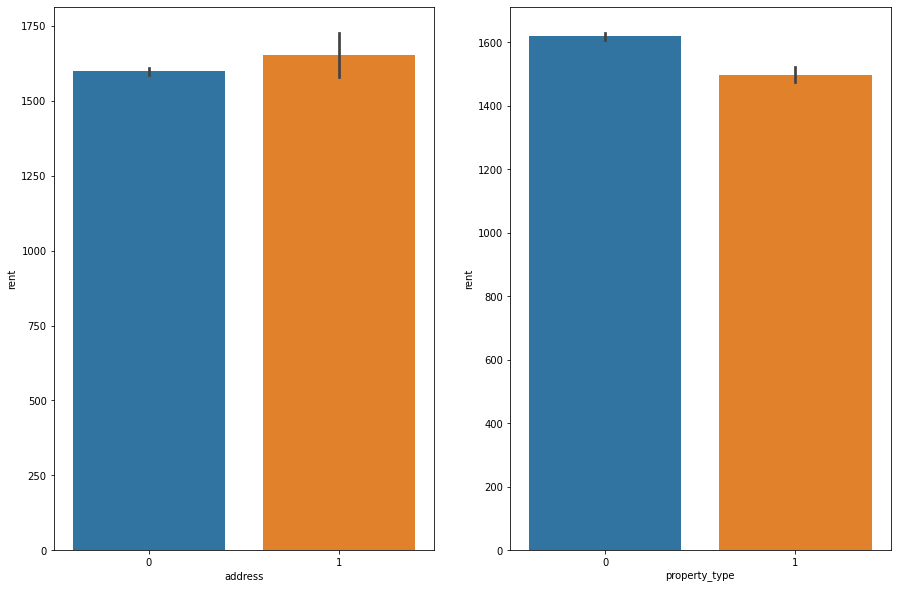

In [129]:
# Visualize the rent for missing and non-missing data for a comparison

temp_df = main_df.copy()
temp_df["address"] = np.where(temp_df["address"].isnull(), 1, 0)
temp_df["property_type"] = np.where(temp_df["property_type"].isnull(), 1, 0)

plt.figure(figsize = (15, 10))
plt.subplot(1, 2, 1)
sns.barplot(x = "address", y = "rent", data = temp_df)
plt.subplot(1, 2, 2)
sns.barplot(x = "property_type", y = "rent", data = temp_df)
plt.show()

### Note: As we see a difference in the values we will need to handle them

In [130]:
# Observing the values and their counts in property_type

main_df["property_type"].value_counts()

Condo       9781
SFR         8171
Duplex      2219
Triplex      330
Quadplex     108
Name: property_type, dtype: int64

In [131]:
# Grouping property type with number of bedrooms since the type of property will have a relation with the number of bedrooms

main_df.groupby("bed")["property_type"].value_counts()

bed  property_type
1    Condo            2610
     SFR               394
2    Condo            3870
     SFR              1553
     Duplex            513
     Triplex             3
     Quadplex            2
3    SFR              3995
     Condo            2502
     Triplex            86
     Duplex              2
     Quadplex            2
4    SFR              1712
     Duplex            936
     Condo             577
     Quadplex           45
5    SFR               409
     Condo             158
     Duplex              2
     Triplex             1
6    Duplex            598
     Triplex           138
     SFR                95
     Condo              54
7    SFR                11
     Condo               5
8    Duplex            137
     Quadplex           39
     Condo               2
9    Triplex            62
     Condo               3
     SFR                 2
     Quadplex            1
10   Duplex             24
12   Triplex            29
     Quadplex           16
     Dupl

In [132]:
# Impute with mode value of Property type for that of bed number

main_df["property_type"] = main_df.groupby("bed")["property_type"].transform(lambda x: x.fillna(x.mode()[0]))

main_df["property_type"].isnull().sum()

0

In [133]:
main_df.drop(['address'], axis = 1, inplace = True)

In [134]:
main_df.shape

(24235, 34)

### Missing Value analysis

County:         0.1 % missing values  - Dropped

Zipcode:        0.1 % missing values  - Dropped

Address:        3.9 % missing values  - Drop address column as it will not provide much information on rent

Property Type:  14.9 % missing values - Impute with mode value of Property type for that number of beds

### Numerical Feature Analysis

In [135]:
# Finding out the numerical features

num_vars = [var for var in main_df.columns if main_df[var].dtypes != 'O']
print("1. Number of Numerical Features: ", len(num_vars))

main_df[num_vars].head()

1. Number of Numerical Features:  29


,zipcode,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,garage,yearbuilt,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent
26,17325.0,39.824860,-77.230730,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,450,0,1940,0,0,0,919.437310,56656.34,4.0,3.53,3.8,625
27,17350.0,39.861755,-77.069725,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,1,1,1130,0,2016,0,0,1,2288.377305,56228.50,4.0,3.27,1.8,1195
28,17350.0,39.900276,-77.044827,5.435821,0.006502,3.139149,5.674612,6.395996,7.132533,2.359260,4.458459,2.346032,68.470710,7.473965,3,1,1,1040,1,1960,0,0,0,2872.730796,56228.50,4.0,3.27,1.8,1195
29,17325.0,30.438256,-84.280733,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,700,0,1960,0,0,0,1736.714919,56656.34,4.0,3.53,3.8,750
30,17325.0,39.831797,-77.236360,0.308556,0.073159,0.053834,13.112389,1.927160,0.515771,0.117654,0.200449,0.586381,78.668268,0.254732,2,1,1,950,1,1973,0,0,0,365.333333,56656.34,4.0,3.53,3.8,950


In [136]:
# Finding out number of features among numerical having Boolean values

boolean_vars = [var for var in num_vars if main_df[var].nunique() == 2]
print("1. Number of Numerical Features: ", len(num_vars))
print("1. a. Number of Boolean Valued Features", len(boolean_vars))

main_df[boolean_vars].head()


1. Number of Numerical Features:  29
1. a. Number of Boolean Valued Features 4


,garage,pool,fireplace,patio
26,0,0,0,0
27,0,0,0,1
28,1,0,0,0
29,0,0,0,0
30,1,0,0,0


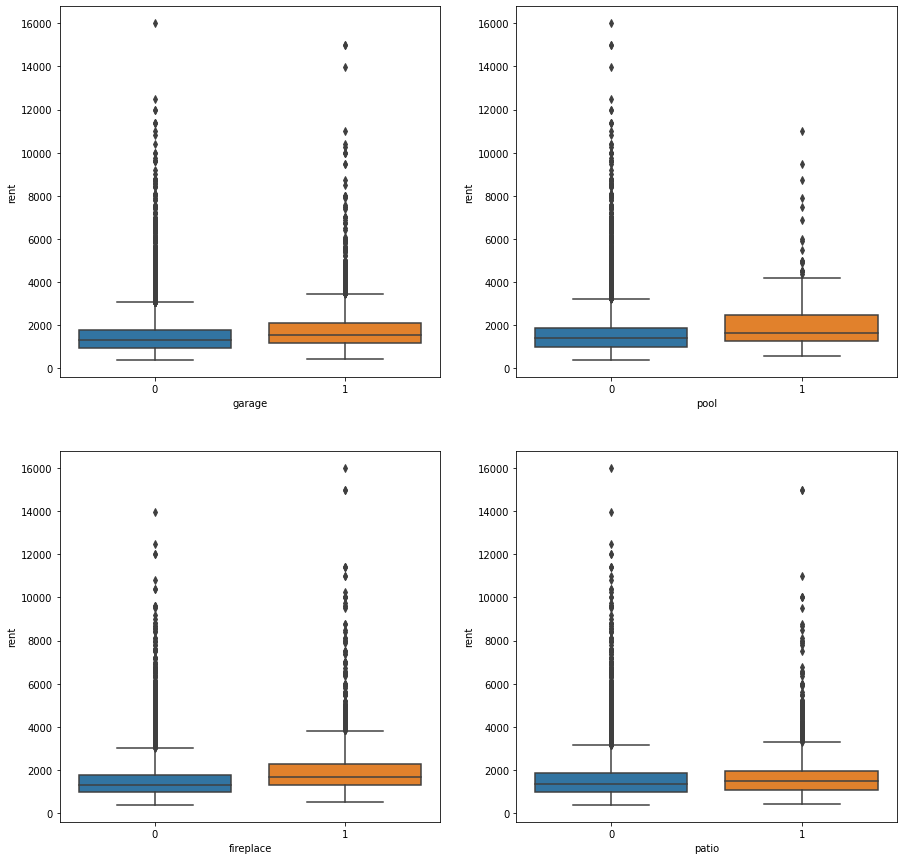

In [137]:
# Visualizing the Boolean Features and their impact on Rent

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'garage', y = 'rent', data = main_df)
plt.subplot(2, 2, 2)
sns.boxplot(x = 'pool', y = 'rent', data = main_df)
plt.subplot(2, 2, 3)
sns.boxplot(x = 'fireplace', y = 'rent', data = main_df)
plt.subplot(2, 2, 4)
sns.boxplot(x = 'patio', y = 'rent', data = main_df)
plt.show()

## Findings 1: 
From the above four Boolean variables we see that in all the 4 cases of garage, pool, fireplace and patio we either have a maximum of 1 of them or none. Hence, we will rename the columns to has_feature_name ie. garage -> has_garage

Having a garage, pool and fireplace has an effect on the rent of the property and on an average the rent is higher if the house has these add-ons. However, having a patio or not does not on an average seem to affect the price of the house.

In [138]:
# Finding out number of features among numerical having Discrete values (Unique values > 2 and < 10)

discrete_vars = [var for var in num_vars if main_df[var].nunique() < 10 and var not in boolean_vars]
print("1. Number of Numerical Features: ", len(num_vars))
print("1. a. Number of Boolean Valued Features", len(boolean_vars))
print("1. b. Number of Discrete Valued Features", len(discrete_vars))

main_df[discrete_vars].head()

1. Number of Numerical Features:  29
1. a. Number of Boolean Valued Features 4
1. b. Number of Discrete Valued Features 1


,halfbath
26,1
27,1
28,1
29,1
30,1


In [139]:
# Finding out number of features among numerical having Discrete values (Unique values > 2 and < 30)

discrete_vars = [var for var in num_vars if main_df[var].nunique() < 20 and var not in boolean_vars]
print("1. Number of Numerical Features: ", len(num_vars))
print("1. a. Number of Boolean Valued Features", len(boolean_vars))
print("1. b. Number of Discrete Valued Features", len(discrete_vars))

main_df[discrete_vars].head()

1. Number of Numerical Features:  29
1. a. Number of Boolean Valued Features 4
1. b. Number of Discrete Valued Features 3


,bed,bath,halfbath
26,1,1,1
27,3,1,1
28,3,1,1
29,1,1,1
30,2,1,1


In [140]:
# Finding number of unique values for each of the discrete features

main_df[discrete_vars].nunique()

bed         14
bath        11
halfbath     8
dtype: int64

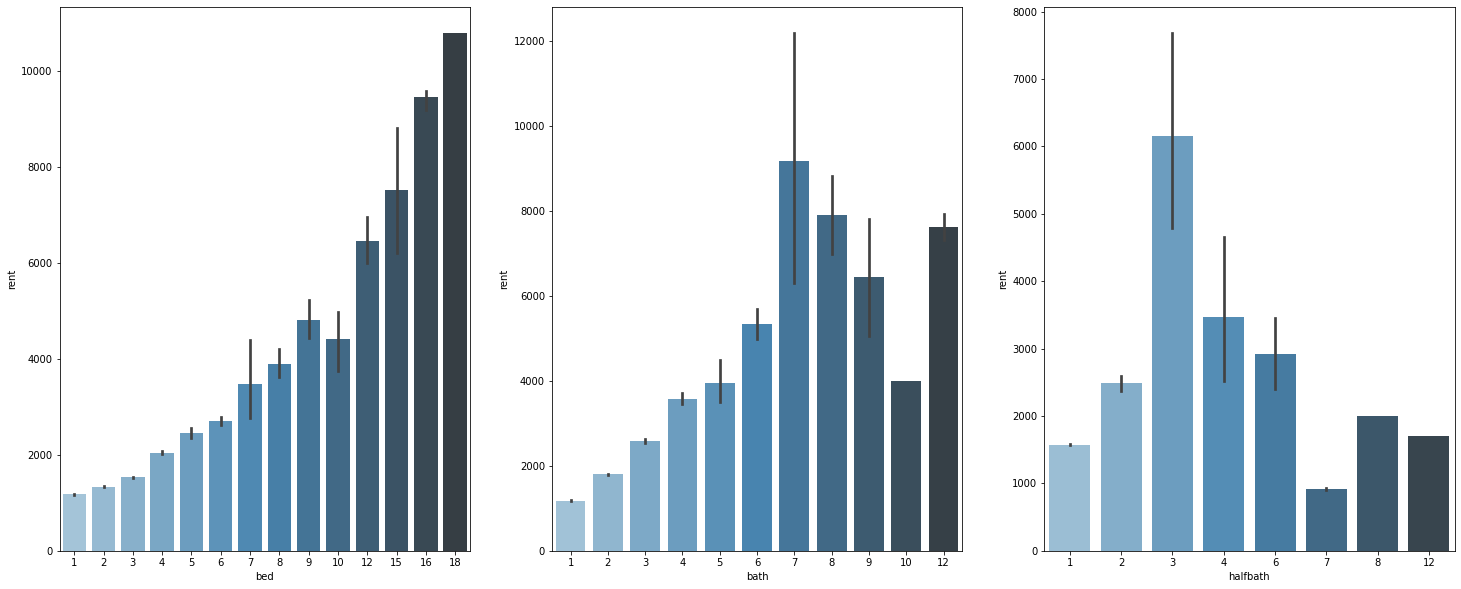

In [141]:
# Visualizing the Discrete Features and their impact on Rent

plt.figure(figsize = (25, 10))
plt.subplot(1, 3, 1)
sns.barplot(x = "bed", y = "rent", data = main_df,  palette="Blues_d")
plt.subplot(1, 3, 2)
sns.barplot(x = "bath", y = "rent", data = main_df,  palette="Blues_d")
plt.subplot(1, 3, 3)
sns.barplot(x = "halfbath", y = "rent", data = main_df,  palette="Blues_d")
plt.show()

## Findings 2: 
Number of Beds have a clear proportional relationship with Rent. The higher the number of bedrooms, higher is the rent. (with a few exceptions. Overall the trend can be captured.)

The number of bathrooms and half-bathrooms do not show this trend clearly. We will combine the number of bathrooms and half-bathrooms at a later point to draw any additional insights

In [142]:
# Finding out number of features among numerical having Continuous values

continuous_vars = [var for var in num_vars if var not in discrete_vars and var not in boolean_vars]
print("1. Number of Numerical Features: ", len(num_vars))
print("1. a. Number of Boolean Valued Features", len(boolean_vars))
print("1. b. Number of Discrete Valued Features", len(discrete_vars))
print("1. b. Number of Continuous Valued Features", len(continuous_vars))

main_df[continuous_vars].head()

1. Number of Numerical Features:  29
1. a. Number of Boolean Valued Features 4
1. b. Number of Discrete Valued Features 3
1. b. Number of Continuous Valued Features 22


,zipcode,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,sqft,yearbuilt,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent
26,17325.0,39.824860,-77.230730,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,450,1940,919.437310,56656.34,4.0,3.53,3.8,625
27,17350.0,39.861755,-77.069725,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1130,2016,2288.377305,56228.50,4.0,3.27,1.8,1195
28,17350.0,39.900276,-77.044827,5.435821,0.006502,3.139149,5.674612,6.395996,7.132533,2.359260,4.458459,2.346032,68.470710,7.473965,1040,1960,2872.730796,56228.50,4.0,3.27,1.8,1195
29,17325.0,30.438256,-84.280733,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,700,1960,1736.714919,56656.34,4.0,3.53,3.8,750
30,17325.0,39.831797,-77.236360,0.308556,0.073159,0.053834,13.112389,1.927160,0.515771,0.117654,0.200449,0.586381,78.668268,0.254732,950,1973,365.333333,56656.34,4.0,3.53,3.8,950


<AxesSubplot:>

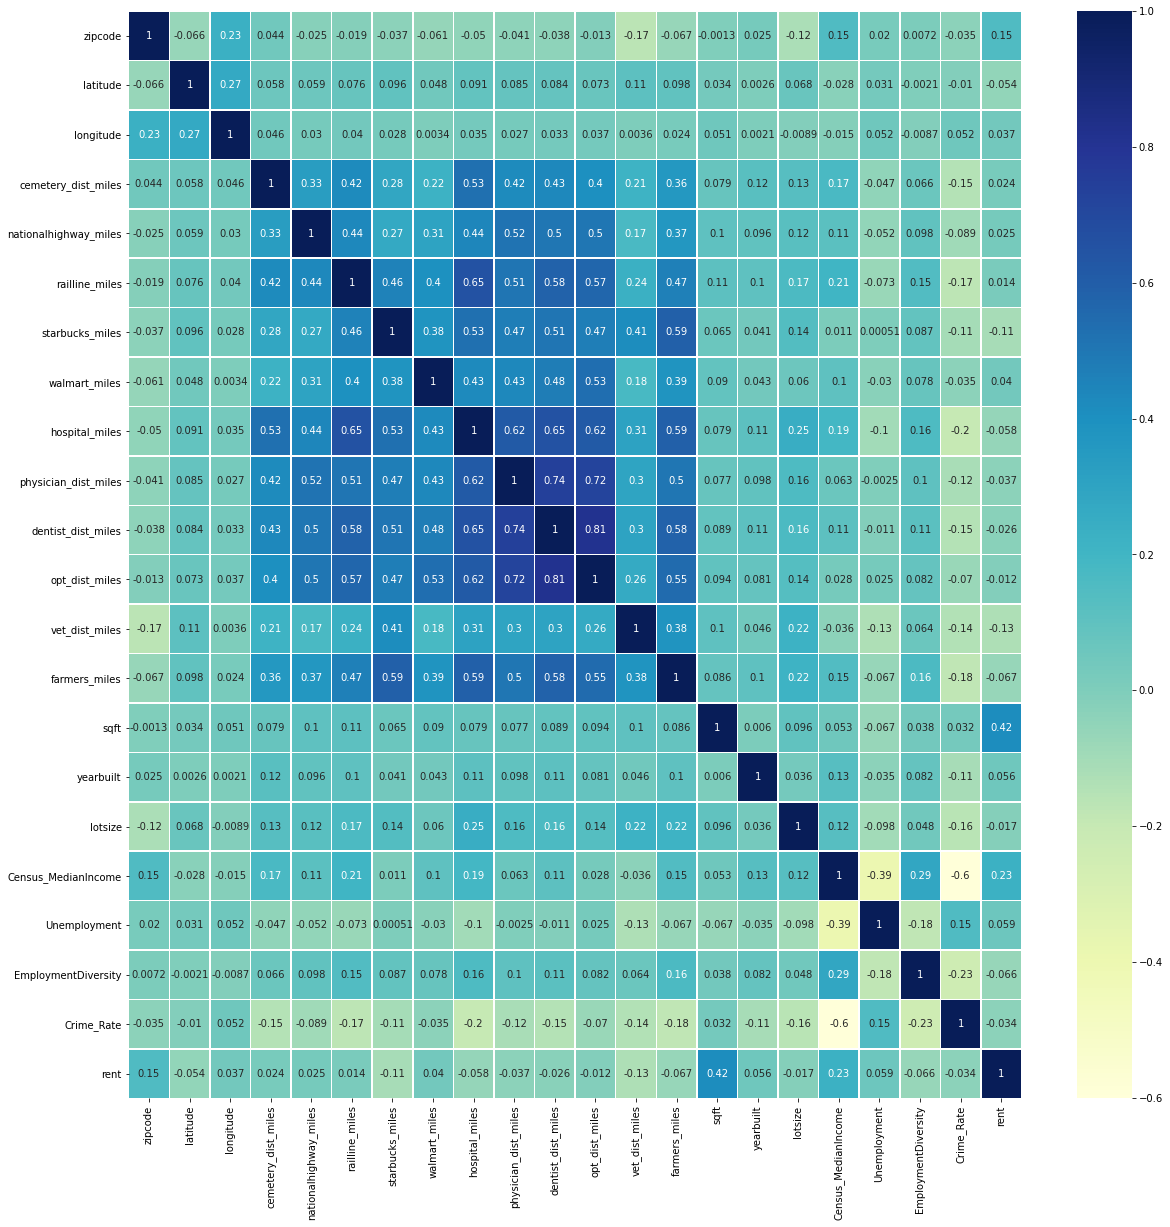

In [143]:
plt.figure(figsize = (20, 20))
sns.heatmap(main_df[continuous_vars].corr(), linewidths = .5, annot = True, cmap = "YlGnBu")

### FIndings 3: 
From the Correlation matrix we see a number of features having high co-relation among them. Since non-collinearity is a Assumption of Linear Regression we might have to deal with them.

### Categorical Features

In [144]:
# Finding out number of Categorical Features

categorical_vars = [var for var in main_df.columns if var not in num_vars]
print("1. Number of Numerical Features: ", len(num_vars))
print("1. a. Number of Boolean Valued Features", len(boolean_vars))
print("1. b. Number of Discrete Valued Features", len(discrete_vars))
print("2. Number of Categorical Features", len(categorical_vars))

main_df[categorical_vars].head()

1. Number of Numerical Features:  29
1. a. Number of Boolean Valued Features 4
1. b. Number of Discrete Valued Features 3
2. Number of Categorical Features 5


,id,county,city,state,property_type
26,train_26,ADAMS,GETTYSBURG,PA,Condo
27,train_27,ADAMS,NEW OXFORD,PA,Condo
28,train_28,ADAMS,NEW OXFORD,PA,SFR
29,train_29,ADAMS,GETTYSBURG,PA,Condo
30,train_30,ADAMS,GETTYSBURG,PA,Condo


In [145]:
# Exploring unique counts in each categorical features

main_df[categorical_vars].nunique()

id               24235
county              64
city               717
state                1
property_type        5
dtype: int64

In [146]:
# Dropping the state feature as it has only one value across all rows

main_df.drop(['state'], axis = 1, inplace = True)

In [147]:
# Creating dummy variables for property_type

main_df = pd.get_dummies(main_df, columns = ['property_type'], drop_first = True)

In [148]:
main_df.head()

,id,county,city,zipcode,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,garage,yearbuilt,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent,property_type_Duplex,property_type_Quadplex,property_type_SFR,property_type_Triplex
26,train_26,ADAMS,GETTYSBURG,17325.0,39.824860,-77.230730,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,450,0,1940,0,0,0,919.437310,56656.34,4.0,3.53,3.8,625,0,0,0,0
27,train_27,ADAMS,NEW OXFORD,17350.0,39.861755,-77.069725,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,1,1,1130,0,2016,0,0,1,2288.377305,56228.50,4.0,3.27,1.8,1195,0,0,0,0
28,train_28,ADAMS,NEW OXFORD,17350.0,39.900276,-77.044827,5.435821,0.006502,3.139149,5.674612,6.395996,7.132533,2.359260,4.458459,2.346032,68.470710,7.473965,3,1,1,1040,1,1960,0,0,0,2872.730796,56228.50,4.0,3.27,1.8,1195,0,0,1,0
29,train_29,ADAMS,GETTYSBURG,17325.0,30.438256,-84.280733,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,700,0,1960,0,0,0,1736.714919,56656.34,4.0,3.53,3.8,750,0,0,0,0
30,train_30,ADAMS,GETTYSBURG,17325.0,39.831797,-77.236360,0.308556,0.073159,0.053834,13.112389,1.927160,0.515771,0.117654,0.200449,0.586381,78.668268,0.254732,2,1,1,950,1,1973,0,0,0,365.333333,56656.34,4.0,3.53,3.8,950,0,0,0,0


In [149]:
# Dropping the features as they have high variablibity and the location is captured by lat and long already

main_df.drop(['county', 'city', 'zipcode'], axis = 1, inplace = True)

### Creating new features

In [150]:
# yearbuilt does not provide much information. An useful feature would be to find out the age of the house using the current year.
# Here we have taken the current year as 2021 to calculate age of property

main_df["age"] = main_df["yearbuilt"].apply(lambda x: 2021 - x)
main_df.drop(['yearbuilt'], axis = 1, inplace = True)
main_df.head()

,id,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,garage,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent,property_type_Duplex,property_type_Quadplex,property_type_SFR,property_type_Triplex,age
26,train_26,39.824860,-77.230730,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,450,0,0,0,0,919.437310,56656.34,4.0,3.53,3.8,625,0,0,0,0,81
27,train_27,39.861755,-77.069725,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,1,1,1130,0,0,0,1,2288.377305,56228.50,4.0,3.27,1.8,1195,0,0,0,0,5
28,train_28,39.900276,-77.044827,5.435821,0.006502,3.139149,5.674612,6.395996,7.132533,2.359260,4.458459,2.346032,68.470710,7.473965,3,1,1,1040,1,0,0,0,2872.730796,56228.50,4.0,3.27,1.8,1195,0,0,1,0,61
29,train_29,30.438256,-84.280733,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,700,0,0,0,0,1736.714919,56656.34,4.0,3.53,3.8,750,0,0,0,0,61
30,train_30,39.831797,-77.236360,0.308556,0.073159,0.053834,13.112389,1.927160,0.515771,0.117654,0.200449,0.586381,78.668268,0.254732,2,1,1,950,1,0,0,0,365.333333,56656.34,4.0,3.53,3.8,950,0,0,0,0,48


In [151]:
# Feature for average bedroom area

main_df["sqft_per_bed"] = main_df["sqft"] / main_df["bed"]
main_df.head()

,id,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,garage,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent,property_type_Duplex,property_type_Quadplex,property_type_SFR,property_type_Triplex,age,sqft_per_bed
26,train_26,39.824860,-77.230730,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,450,0,0,0,0,919.437310,56656.34,4.0,3.53,3.8,625,0,0,0,0,81,450.000000
27,train_27,39.861755,-77.069725,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,1,1,1130,0,0,0,1,2288.377305,56228.50,4.0,3.27,1.8,1195,0,0,0,0,5,376.666667
28,train_28,39.900276,-77.044827,5.435821,0.006502,3.139149,5.674612,6.395996,7.132533,2.359260,4.458459,2.346032,68.470710,7.473965,3,1,1,1040,1,0,0,0,2872.730796,56228.50,4.0,3.27,1.8,1195,0,0,1,0,61,346.666667
29,train_29,30.438256,-84.280733,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,700,0,0,0,0,1736.714919,56656.34,4.0,3.53,3.8,750,0,0,0,0,61,700.000000
30,train_30,39.831797,-77.236360,0.308556,0.073159,0.053834,13.112389,1.927160,0.515771,0.117654,0.200449,0.586381,78.668268,0.254732,2,1,1,950,1,0,0,0,365.333333,56656.34,4.0,3.53,3.8,950,0,0,0,0,48,475.000000


In [152]:
# Feature for total number of bathrooms

main_df["bathroom_combined"] = main_df["bath"] + (0.5 * main_df["halfbath"])
main_df.head()

,id,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,vet_dist_miles,farmers_miles,bed,bath,halfbath,sqft,garage,pool,fireplace,patio,lotsize,Census_MedianIncome,Unemployment,EmploymentDiversity,Crime_Rate,rent,property_type_Duplex,property_type_Quadplex,property_type_SFR,property_type_Triplex,age,sqft_per_bed,bathroom_combined
26,train_26,39.824860,-77.230730,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,450,0,0,0,0,919.437310,56656.34,4.0,3.53,3.8,625,0,0,0,0,81,450.000000,1.5
27,train_27,39.861755,-77.069725,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,3,1,1,1130,0,0,0,1,2288.377305,56228.50,4.0,3.27,1.8,1195,0,0,0,0,5,376.666667,1.5
28,train_28,39.900276,-77.044827,5.435821,0.006502,3.139149,5.674612,6.395996,7.132533,2.359260,4.458459,2.346032,68.470710,7.473965,3,1,1,1040,1,0,0,0,2872.730796,56228.50,4.0,3.27,1.8,1195,0,0,1,0,61,346.666667,1.5
29,train_29,30.438256,-84.280733,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,7.323725,1.094678,1,1,1,700,0,0,0,0,1736.714919,56656.34,4.0,3.53,3.8,750,0,0,0,0,61,700.000000,1.5
30,train_30,39.831797,-77.236360,0.308556,0.073159,0.053834,13.112389,1.927160,0.515771,0.117654,0.200449,0.586381,78.668268,0.254732,2,1,1,950,1,0,0,0,365.333333,56656.34,4.0,3.53,3.8,950,0,0,0,0,48,475.000000,1.5


In [153]:
main_df.drop(['bath', 'halfbath'], axis = 1, inplace = True)

In [154]:
# Creating a premium_house feature having pool, garage, fireplace and bedrooms > 3 and bathrooms > 3

main_df["is_premium_house"] = main_df.apply(create_premium_house_feature, axis = 1)
main_df["is_premium_house"].value_counts()

0    24192
1       43
Name: is_premium_house, dtype: int64

<AxesSubplot:xlabel='is_premium_house', ylabel='rent'>

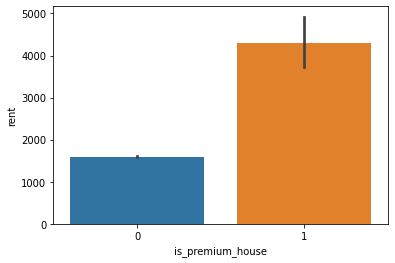

In [155]:
sns.barplot(x = "is_premium_house", y = "rent", data = main_df)

We can see that our classification of premium houses makes sense in the context as these houses tend to have much higher rent than the others

## Skewness Handling for Continuous variables

In [111]:
main_df.skew()

latitude                  -7.718027
longitude                 -6.149499
cemetery_dist_miles        3.587480
nationalhighway_miles      5.382280
railline_miles             5.741890
starbucks_miles            7.923096
walmart_miles              2.567374
hospital_miles             3.880562
physician_dist_miles       6.734854
dentist_dist_miles         5.540060
opt_dist_miles             5.926615
vet_dist_miles             3.272280
farmers_miles              4.107949
bed                        1.933263
sqft                       1.582058
garage                     0.916435
pool                       9.175962
fireplace                  1.447579
patio                      1.515328
lotsize                    2.157666
Census_MedianIncome        0.697426
Unemployment               0.120312
EmploymentDiversity       -1.513163
Crime_Rate                 1.366336
rent                       3.437563
property_type_Duplex       2.821418
property_type_Quadplex    14.880525
property_type_SFR          0

In [112]:
skewed_feature_list = ["cemetery_dist_miles", "nationalhighway_miles", "railline_miles", "starbucks_miles", "walmart_miles", "hospital_miles", "physician_dist_miles", "dentist_dist_miles", "opt_dist_miles", "vet_dist_miles", "farmers_miles", "sqft_per_bed"]

main_df[skewed_feature_list] = np.log(main_df[skewed_feature_list])

In [113]:
main_df[skewed_feature_list].skew()

cemetery_dist_miles     -0.298958
nationalhighway_miles   -1.375757
railline_miles          -0.142859
starbucks_miles         -0.024315
walmart_miles           -0.932110
hospital_miles          -0.001961
physician_dist_miles    -0.283044
dentist_dist_miles      -0.466129
opt_dist_miles          -0.191117
vet_dist_miles          -0.422994
farmers_miles            0.049823
sqft_per_bed             0.505502
dtype: float64

## Splitting Data in Train and Test



In [156]:
# Data without Scaling

y = main_df['rent']
X = main_df.drop(['rent', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [116]:
df = main_df.drop(['id'], axis = 1)

In [46]:
# Data with Scaling

df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

rs = RobustScaler()
rs.fit_transform(df_train)
rs.transform(df_test)

y_train_scaled = df_train.pop("rent")
X_train_scaled = df_train

y_test_scaled = df_test.pop("rent")
X_test_scaled = df_test

## Model Building

### Model 1: Linear Regression with all features

In [47]:
model_1 = LinearRegression()
model_1.fit(X_train_scaled, y_train_scaled)

rfe = RFE(model_1, 35)
rfe = rfe.fit(X_train_scaled, y_train_scaled)

col_rfe = X_train_scaled.columns[rfe.support_]
X_train_temp = X_train_scaled[col_rfe]

X_train_sm = sm.add_constant(X_train_temp)
ols_1 = sm.OLS(y_train_scaled, X_train_sm).fit()
print(ols_1.summary())
get_VIF(X_train_sm)

C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=35 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     1015.
Date:                Fri, 06 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:57:23   Log-Likelihood:                -1778.8
No. Observations:               16964   AIC:                             3624.
Df Residuals:                   16931   BIC:                             3879.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

#### Note: On the first attempt with all features we see that we have p values greater than 0.05 for a few features. We will now use the power of RFE to select the best 30 features

## Model 2: Linear Regression with 25 features

In [48]:
model_2 = LinearRegression()
model_2.fit(X_train_scaled, y_train_scaled)

rfe = RFE(model_2, 25)
rfe = rfe.fit(X_train_scaled, y_train_scaled)

col_rfe = X_train_scaled.columns[rfe.support_]
X_train_temp = X_train_scaled[col_rfe]

X_train_sm = sm.add_constant(X_train_temp)
ols_2 = sm.OLS(y_train_scaled, X_train_sm).fit()
print(ols_2.summary())
get_VIF(X_train_sm)

C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1001.
Date:                Fri, 06 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:57:37   Log-Likelihood:                -3171.0
No. Observations:               16964   AIC:                             6394.
Df Residuals:                   16938   BIC:                             6595.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

## Model 3: Linear Regression with 24 features

In [49]:
# Dropping feature with highest p-value above 0.05

X_train_temp = X_train_temp.drop(["property_type_Duplex"], axis = 1)

X_train_sm = sm.add_constant(X_train_temp)
ols_3 = sm.OLS(y_train_scaled, X_train_sm).fit()
print(ols_3.summary())
get_VIF(X_train_sm)

C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1043.
Date:                Fri, 06 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:57:58   Log-Likelihood:                -3172.0
No. Observations:               16964   AIC:                             6394.
Df Residuals:                   16939   BIC:                             6587.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

## Model 4: Linear Regression with 23 features

In [50]:
# Dropping feature with highest p-value above 0.05

X_train_temp = X_train_temp.drop(["opt_dist_miles"], axis = 1)

X_train_sm = sm.add_constant(X_train_temp)
ols_4 = sm.OLS(y_train_scaled, X_train_sm).fit()
print(ols_4.summary())
get_VIF(X_train_sm)

C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     1088.
Date:                Fri, 06 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:58:07   Log-Likelihood:                -3173.9
No. Observations:               16964   AIC:                             6396.
Df Residuals:                   16940   BIC:                             6582.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

#### Note: We now have the feature set with non-multicollinearity

In [51]:
feature_list = X_train_temp.columns
feature_list

Index(['latitude', 'cemetery_dist_miles', 'nationalhighway_miles',
       'starbucks_miles', 'walmart_miles', 'hospital_miles',
       'physician_dist_miles', 'dentist_dist_miles', 'vet_dist_miles',
       'farmers_miles', 'bed', 'garage', 'pool', 'fireplace', 'patio',
       'Unemployment', 'EmploymentDiversity', 'Crime_Rate',
       'property_type_Quadplex', 'property_type_SFR', 'property_type_Triplex',
       'sqft_per_bed', 'bathroom_combined'],
      dtype='object')

In [52]:
model_4 = LinearRegression()
model_4_scaled = LinearRegression()

model_4.fit(X_train[feature_list], y_train)
y_train_pred = model_4.predict(X_train[feature_list])

model_4_scaled.fit(X_train_scaled[feature_list], y_train_scaled)
y_train_scaled_pred = model_4_scaled.predict(X_train_scaled[feature_list])

C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Error Distribution')

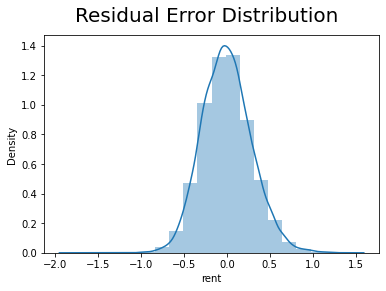

In [53]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Residual Error Distribution', fontsize = 20)

C:\Users\tm068664\Anaconda3\envs\Python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Error Distribution - Scaled')

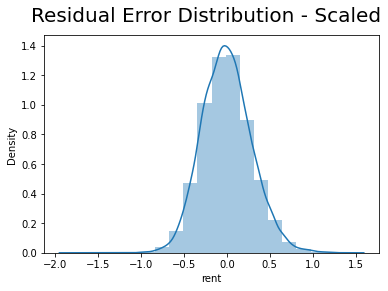

In [54]:
fig = plt.figure()
sns.distplot((y_train_scaled - y_train_scaled_pred), bins = 20)
fig.suptitle('Residual Error Distribution - Scaled', fontsize = 20)

#### Note: The residual errors are distributed in a bell shaped curve with the mean centered at 0.0. It is showing a good Normal Distribution curve

## Model Evaluation - RMSE


In [55]:
rmse = sqrt(mean_squared_error(y_train_scaled, y_train_scaled_pred))
r2 = r2_score(y_train_scaled, y_train_scaled_pred)
print('Model RMSE scaled:',rmse)
print('Model r2_score scaled:',r2)

Model RMSE scaled: 0.2917544145705498
Model r2_score scaled: 0.5962145781035306


## Model 5: Random Forest Regressor

#### Tuning n_estimators

In [56]:
parameters = {'n_estimators': range(50, 150, 25)}
rf = RandomForestRegressor(random_state = 42)
rfgs = GridSearchCV(rf, parameters, cv = 3, scoring = "neg_root_mean_squared_error", return_train_score = True)
rfgs.fit(X_train, y_train)

rfgs.best_params_, rfgs.best_score_

({'n_estimators': 125}, -0.19925162911596198)

#### Tuning min_samples_split

In [57]:
parameters = {'min_samples_split': range(2, 10, 2)}
rf = RandomForestRegressor(n_estimators = 125, random_state = 42)
rfgs = GridSearchCV(rf, parameters, cv = 3, scoring = "neg_root_mean_squared_error", return_train_score = True)
rfgs.fit(X_train, y_train)

rfgs.best_params_, rfgs.best_score_

({'min_samples_split': 2}, -0.19925162911596198)

#### Tuning min_samples_leaf

In [58]:
parameters = {'min_samples_leaf': range(1, 10, 2)}
rf = RandomForestRegressor(n_estimators = 125, min_samples_split = 2, random_state = 42)
rfgs = GridSearchCV(rf, parameters, cv = 3, scoring = "neg_root_mean_squared_error", return_train_score = True)
rfgs.fit(X_train, y_train)

rfgs.best_params_, rfgs.best_score_

({'min_samples_leaf': 1}, -0.19925162911596198)

#### Tuning max_depth

In [59]:
parameters = {'max_depth': range(5, 30, 5)}
rf = RandomForestRegressor(n_estimators = 125, min_samples_split = 2, min_samples_leaf = 1, random_state = 42)
rfgs = GridSearchCV(rf, parameters, cv = 3, scoring = "neg_root_mean_squared_error", return_train_score = True)
rfgs.fit(X_train, y_train)

rfgs.best_params_, rfgs.best_score_

({'max_depth': 25}, -0.19916806897632952)

In [60]:
model_5 = RandomForestRegressor(n_estimators = 125, min_samples_split = 2, min_samples_leaf = 1, max_depth = 25, random_state = 42)
model_5.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=125, random_state=42)

In [61]:
y_train_pred = model_5.predict(X_train)
y_test_pred = model_5.predict(X_test)

rmse = sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)
print('Train')
print('Model RMSE scaled:', rmse)
print('Model r2_score scaled:', r2)

rmse = sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print('Test')
print('Model RMSE scaled:', rmse)
print('Model r2_score scaled:', r2)

Train
Model RMSE scaled: 0.07243676045749524
Model r2_score scaled: 0.9751094896232664
Test
Model RMSE scaled: 0.18403636839997373
Model r2_score scaled: 0.8335773482393873


## Model 6: Tuning Random Forest a bit more to reduce Overfitting trends

In [62]:
model_6 = RandomForestRegressor(n_estimators = 125, min_samples_split = 2, min_samples_leaf = 1, max_depth = 10, random_state = 42)
model_6.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=125, random_state=42)

In [63]:
y_train_pred = model_6.predict(X_train)
y_test_pred = model_6.predict(X_test)

rmse = sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)
print('Train')
print('Model RMSE scaled:', rmse)
print('Model r2_score scaled:', r2)

rmse = sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print('Test')
print('Model RMSE scaled:', rmse)
print('Model r2_score scaled:', r2)

Train
Model RMSE scaled: 0.16899743864137887
Model r2_score scaled: 0.8645197442309066
Test
Model RMSE scaled: 0.20132538024486962
Model r2_score scaled: 0.800839969399215


## Model 7: XGBoost

In [161]:
model_7 = XGBRegressor(learning_rate = 0.1, n_estimators = 125, min_samples_split = 2, min_samples_leaf = 1, max_depth = 10, subsample = 1.0, random_state = 42)
model_7.fit(X_train, y_train)

[23:25:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, min_samples_leaf=1, min_samples_split=2,
             missing=nan, monotone_constraints='()', n_estimators=125, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1.0, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [162]:
y_train_pred = model_7.predict(X_train)
y_test_pred = model_7.predict(X_test)

rmse = sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)
print('Train')
print('Model RMSE:', rmse)
print('Model r2_score:', r2)

rmse = sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print('Test')
print('Model RMSE:', rmse)
print('Model r2_score:', r2)

Train
Model RMSE: 132.7912691226337
Model r2_score: 0.9791917509945074
Test
Model RMSE: 363.78439232764595
Model r2_score: 0.8391550509975788


## Model 8: XGBoost with tuning max_depth to remove a bit more of the overfitting

In [170]:
model_8 = XGBRegressor(learning_rate = 0.1, n_estimators = 125, min_samples_split = 2, min_samples_leaf = 1, max_depth = 5, subsample = 1.0, random_state = 42)
model_8.fit(X_train, y_train)

[23:27:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, min_samples_leaf=1, min_samples_split=2,
             missing=nan, monotone_constraints='()', n_estimators=125, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1.0, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [171]:
y_train_pred = model_8.predict(X_train)
y_test_pred = model_8.predict(X_test)

rmse = sqrt(mean_squared_error(y_train, y_train_pred))
r2 = r2_score(y_train, y_train_pred)
print('Train')
print('Model RMSE:', rmse)
print('Model r2_score:', r2)

rmse = sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
print('Test')
print('Model RMSE:', rmse)
print('Model r2_score:', r2)

Train
Model RMSE: 305.04462701171406
Model r2_score: 0.8901947126601503
Test
Model RMSE: 382.85262587484834
Model r2_score: 0.8218513387796326


#### NOTE: Finally we have a model which is giving us decent scores. We have also been able to do away with a big part of the overfitting.

## Feature Importances - XGBoost

In [172]:
model_8.get_booster().get_score(importance_type = 'weight')

{'bathroom_combined': 244,
 'Census_MedianIncome': 257,
 'longitude': 449,
 'bed': 177,
 'latitude': 413,
 'Unemployment': 92,
 'starbucks_miles': 149,
 'sqft': 339,
 'EmploymentDiversity': 114,
 'farmers_miles': 82,
 'railline_miles': 85,
 'Crime_Rate': 72,
 'vet_dist_miles': 114,
 'sqft_per_bed': 169,
 'cemetery_dist_miles': 77,
 'walmart_miles': 78,
 'nationalhighway_miles': 82,
 'lotsize': 126,
 'dentist_dist_miles': 65,
 'property_type_SFR': 16,
 'property_type_Triplex': 13,
 'physician_dist_miles': 51,
 'hospital_miles': 65,
 'opt_dist_miles': 69,
 'property_type_Duplex': 22,
 'fireplace': 26,
 'age': 57,
 'garage': 16,
 'pool': 7,
 'patio': 14,
 'property_type_Quadplex': 9,
 'is_premium_house': 1}

## Important Features is deciding the rent of a house

- location : Both latitude and longitude have the highest weights which explain that the location of a house is one of the biggest drivers for deciding the rent
- sqft : The area of the property is the next best deciding factor for rent
- Census_MedianIncome: The median income of the locality also plays a factor in deciding the rent.
- Number of bathroom, Number of bedrooms, proximity to diff areas of interest seem to have an effect on the rent as well but not as profound as the ones above.

## Storing models for use

In [173]:
# Storing the XGBoost Regressor final model

xgb_file = open("../models/XGBoost_Regressor_tunned.pickle", "wb")
pickle.dump(model_8, xgb_file)
xgb_file.close()